### Evaluación del modelo en condiciones aproximadas a producción
(estimación de rentabilidad del sistema)

#### Importamos librerías necesarias

In [16]:
import sys
sys.path.append("../") # go to parent dir

In [17]:
import os

In [18]:
os.getcwd()

'C:\\Programacion\\PD\\forecasts'

In [19]:
import pickle
from modelos import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Cargamos los datos de forecast y las observaciones que hemos usado para entrenamiento, para poder sacar el orden de las columnas

In [20]:
df_observ = pd.read_parquet("../clean/df_definitivo.parquet")

# eliminamos repetidas, columnas que no participan en el modelo
df_observ.drop(columns=['Temperatura', 'wspd'], inplace=True) 

df_forecast = pd.read_csv('./clean/forecast_merged.csv')

In [21]:
df_forecast.columns

Index(['Vviento', 'PeriodoOlas', 'Nubosidad', 'Lluvia', 'antelacion', 'hora',
       'dia', 'anio', 'mes', 'temp', 'dewPt', 'heat_index', 'rh', 'pressure',
       'vis', 'wc', 'feels_like', 'uv_index', 'wdir_E', 'wdir_ENE', 'wdir_ESE',
       'wdir_N', 'wdir_NE', 'wdir_NNE', 'wdir_NNW', 'wdir_NW', 'wdir_S',
       'wdir_SE', 'wdir_SSE', 'wdir_SSW', 'wdir_SW', 'wdir_VAR', 'wdir_W',
       'wdir_WNW', 'wdir_WSW', 'moonphase', 'AlturaOlas'],
      dtype='object')

In [22]:
df_forecast[["anio", "mes", "dia", "hora","antelacion", "moonphase", "AlturaOlas"]].iloc[20:45,:]

,anio,mes,dia,hora,antelacion,moonphase,AlturaOlas
20,2024,5,3,15,2,0.84,0.7
21,2024,5,3,16,3,0.84,0.6
22,2024,5,3,17,4,0.84,0.6
23,2024,5,3,18,5,0.84,0.6
24,2024,5,3,19,6,0.84,0.6
25,2024,5,3,20,7,0.84,0.6
26,2024,5,3,21,8,0.84,0.7
27,2024,5,3,22,9,0.84,0.6
28,2024,5,3,23,10,0.84,0.7
29,2024,5,3,14,0,0.84,0.7


##### Para mantener el mismo orden de columnas en el input del modelo

In [23]:
antelaciones = df_forecast['antelacion'] # guardamos para evaluar posteriormente
df_forecast = df_forecast[df_observ.columns]

#### Separamos en explicativas y respuesta

In [24]:
X, y = df_forecast.drop(columns=['AlturaOlas', 'anio', 'mes', 'dia', 'hora']), df_forecast['AlturaOlas']

#### Cargamos el modelo definitivo

In [25]:
filename = '../modelos/modelo_definitivo/modelo_rf_def.pkl'

with open(filename, 'rb') as file:
    model = pickle.load(file)

model

RandomForestRegressor(max_depth=28, min_samples_leaf=4, min_samples_split=4,
                      n_estimators=201, random_state=777)

Obtenemos la escala de los datos de entrenamiento

In [26]:
filename = '../modelos/modelo_definitivo/scaler.pkl'

with open(filename, 'rb') as file:
    scaler = pickle.load(file)


scaler

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['moonphase', 'temp', 'dewPt', 'heat_index',
                                  'rh', 'pressure', 'vis', 'wc', 'feels_like',
                                  'uv_index', 'Vviento', 'PeriodoOlas',
                                  'Lluvia', 'Nubosidad'])])

In [28]:
filtro_observaciones_reales = ~y.isna()
filtro_observaciones_reales.sum()

608

Para medir el éxito de las predicciones necesitamos esperar hasta que el suceso se haya dado y comparar. Es decir, para comprobar cómo de buena ha sido nuestra predicción de las olas a las 14h necesitamos que pasen las 14h, recoger la altura real y compararlo con nuestra predicción.

Es por eso que nuestra columna y (AlturaOlas) tiene muchos NaNs, pues se tratan de observaciones que son futuras al momento actual.

Para hacer el análisis únicamente podemos usar datos que ya han sido confirmados. En un futuro cuando las predicciones tengan un valor real con el cual compararse, obtendremos un mayor espacio de predicciones con el cual medir el rendimiento del modelo.

In [29]:
X_obs_reales = X[filtro_observaciones_reales]
y_obs_reales = y[filtro_observaciones_reales]
antelacion_obs_reales = antelaciones[filtro_observaciones_reales]

In [30]:
# predicciones = model.predict(X)
predicciones_obs_reales = model.predict(scaler.transform(X_obs_reales))

In [31]:
# calcular_metricas(y, predicciones)
calcular_metricas(y_obs_reales, predicciones_obs_reales)

{'TEST_MAX_ERROR': 0.6023284875710251,
 'TEST_ROOT_MEAN_SQ_ERROR': 0.17027872433940208,
 'TEST_MEDIAN_ABS_ERROR': 0.11052063218217767,
 'TEST_MEAN_ABS_ERROR': 0.1321530063392821}

Text(0.5, 0, 'TRUE (metros)')

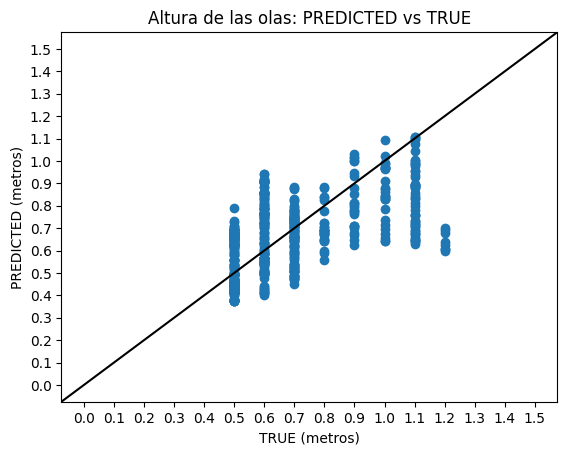

In [32]:
plt.scatter(y_obs_reales, predicciones_obs_reales)
plt.xticks([i/10 for i in range(0,16)])
plt.yticks([i/10 for i in range(0,16)])
plt.axline([0,0], [1.5, 1.5], color='0')
plt.title('Altura de las olas: PREDICTED vs TRUE')

plt.ylabel('PREDICTED (metros)')
plt.xlabel('TRUE (metros)')

#### Ahora pasaríamos a analizar el error en función de la antelación de la predicción

Text(0.5, 0, 'TRUE (metros)')

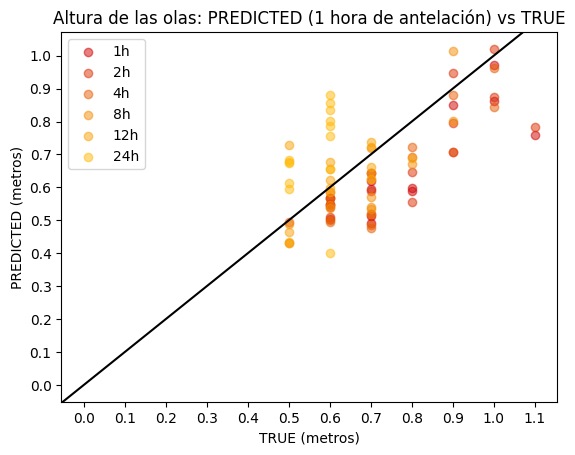

In [33]:
colores = ["#d00000","#dc2f02","#e85d04","#f48c06","#faa307","#ffba08"]
hours = [1,2,4,8,12,24]
for i, h in enumerate(hours):
    plt.scatter(y_obs_reales[antelacion_obs_reales == h], predicciones_obs_reales[antelacion_obs_reales == h], color=colores[i], alpha=0.5, label=f'{h}h')
plt.legend()
plt.xticks([i / 10 for i in range(0, 16)])
plt.yticks([i / 10 for i in range(0, 16)])
plt.axline([0, 0], [1, 1], color='0')
plt.title('Altura de las olas: PREDICTED (1 hora de antelación) vs TRUE')

plt.ylabel('PREDICTED (metros)')
plt.xlabel('TRUE (metros)')